# scATAC-seq preprocessing using pycisTopic

In [1]:
!jt

/g/easybuild/x86_64/Rocky/8/haswell/software/Python/3.9.6-GCCcore-11.2.0/bin/python3.9: error while loading shared libraries: libpython3.9.so.1.0: cannot open shared object file: No such file or directory


In [3]:
# SET UP ENVIRONMENT

#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
_stderr = sys.stderr
null = open(os.devnull,'wb')

# set the working directory (now set locally)
import os
work_dir = '/g/scb/zaugg/deuner/SCENIC+/'

# set tmp directory
tmp_dir = '/g/scb/zaugg/deuner/SCENIC+/tmp/'

# set the figures directory
fig_dir = '/g/scb/zaugg/deuner/SCENIC+/figures/'

!pip install -q umap-learn==0.5.1

In [1]:
# Load libraries
import scanpy as sc
import numpy as np
import matplotlib.pyplot as pl
from scipy import io
import pandas as pd

In [4]:
# Specify the location of the ATAC fragments file, this is the main input into pycisTopic.
fragments_dict = {'timecourse': os.path.join(work_dir, 'inputdata/timecourse_fragments_translated_ordered4.tsv')}

### Generate pseudobulk ATAC-seq profiles, call peaks and generate a consensus peak set

In [5]:
# First load the cell type annotation we generated in the scRNA-seq analysis above.
adata = sc.read_h5ad(os.path.join(work_dir, 'tmp/timecourse.nomicro.subset.adata.h5ad'))

In [6]:
# Set barcodes as cell names
new_names = []
for i in range(len(adata.obs_names)):
    new_name = adata.obs_names[i][11:]
    new_names.append(new_name)

adata.obs_names = new_names

In [8]:
cell_data = adata.obs
cell_data['sample_id'] = 'timecourse'
cell_data['celltype'] = cell_data['celltype_wnn'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.

In [9]:
cell_data

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.ribo,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,pANN_0.25_0.005_794,...,celltype,basic_celltype,pseudotime,pseudotime_clusters_n7,pseudotime_clusters_n14,wsnn_res.0.8,celltype_wnn,sampleID,barcode,sample_id
GCGGTTGGTAACGTGC,timecourse,7372.0,3241,11.516549,2.902876,7372.0,3241,0,1,0.098592,...,diff - NPC-like,diff,24.902457,3,5,8,diff - NPC-like,timecourse,GCCTCAATGACAGAAC,timecourse
AAGCCTCCAATCCTGA,timecourse,5596.0,2285,0.178699,0.321658,6674.0,2283,4,4,0.056338,...,neuron - mature.neuron,neuron,59.514298,6,12,4,neuron - mature.neuron,timecourse,ATTGTCTACTAAAGCT,timecourse
GGCTGTCAGTTGTCCC,timecourse,6767.0,3109,9.915768,3.058963,6935.0,3108,0,1,0.056338,...,diff - NPC-like,diff,23.183780,3,5,8,diff - NPC-like,timecourse,TTTGTACGAGTAACTA,timecourse
AGAGATTAGGGTCTAT,timecourse,3941.0,2071,0.355240,0.761228,6663.0,2089,5,5,0.084507,...,neuron - excitatory,neuron,37.680784,4,8,6,neuron - excitatory,timecourse,GATTTGAGAAGTAATC,timecourse
TCGTTATTCGCCTAAG,timecourse,2149.0,1407,11.633318,2.326664,6189.0,1968,2,2,0.183099,...,diff,diff,31.633097,4,7,1,diff,timecourse,CCCTTTACTACAAACA,timecourse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAGTAACCATCCTAGA,timecourse,4619.0,2664,2.359818,2.208270,6478.0,2666,0,1,0.253521,...,diff - NPC-like,diff,25.236132,3,6,2,diff - NPC-like,timecourse,AAGACAAACTTGCTCA,timecourse
TCTAACCGTTGGTTCT,timecourse,6192.0,2610,4.731912,0.645995,6780.0,2609,6,5,0.070423,...,neuron - excitatory,neuron,42.729866,5,9,6,neuron - excitatory,timecourse,AGCCTTGTGCATCCCT,timecourse
CATAATCCATGTCGCG,timecourse,4049.0,2435,3.754013,1.778217,6620.0,2447,0,1,0.084507,...,diff - NPC-like,diff,25.116435,3,6,2,diff - NPC-like,timecourse,CTAACTCACAATACCG,timecourse
TTTGCGACAGTTATCG,timecourse,22122.0,5835,0.226019,0.479161,7707.0,3437,10,7,0.070423,...,mature.neuron - adhesion,neuron,57.454289,6,12,7,mature.neuron - adhesion,timecourse,GGAATAAACCTCACAT,timecourse


In [10]:
# Generate pseudobulk profiles 
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [11]:
# Check chromsizes
chromsizes

,Chromosome,Start,End
0,GL000008.2,0,209709
1,GL000009.2,0,201709
2,GL000194.1,0,191469
3,GL000195.1,0,182896
4,GL000205.2,0,185591
...,...,...,...
450,chr21,0,46709983
451,chr22,0,50818468
452,chrM,0,16569
453,chrX,0,156040895


In [12]:
# Load fragments
fragments = pd.read_table(os.path.join(work_dir, 'inputdata/timecourse_fragments_translated_ordered4.tsv'), header=None)

In [26]:
'''
complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}

def reverse_complement(seq):
    comp = ""
    for base in seq:
        comp += complement[base]
    
    return comp[::-1]
'''

'CGAT'

In [31]:
'''
rev_comp_frags = []
for barcode in sorter:
    rev_comp = reverse_complement(barcode)
    rev_comp_frags.append(rev_comp)
    
rev_comp_cells = []
for barcode in barcodes_cell_data:
    rev_comp = reverse_complement(barcode)
    rev_comp_cells.append(rev_comp)
'''

In [13]:
# Get barcodes in fragments and cell_data
sorter = fragments[3].unique().tolist()
barcodes_cell_data = cell_data.index.values.tolist()

In [14]:
# Get file with ATAC and RNA barcodes matchings
barcodes_df = pd.read_csv(os.path.join(work_dir, "inputdata/cellBarcodes.rna.atac.timecourse.txt"), sep = " ")
barcodes_dict = dict()

# Create a dictionary where keys are rna barcodes and values atac barcodes
for i in range(len(barcodes_df.index.values)):
    barcodes_dict[barcodes_df.iloc[i,0]] = barcodes_df.iloc[i,1]

In [15]:
# Add a barcode column in cell data (with correspondent atac barcode for each cell)
cell_data['barcode'] = [""]*len(cell_data.index.values)
for i in range(len(cell_data.index.values)):
    rna_barcodes = cell_data.index.values
    cell_data['barcode'][i] = barcodes_dict[rna_barcodes[i]]

/tmp/ipykernel_3197405/693655966.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data['barcode'][i] = barcodes_dict[rna_barcodes[i]]


In [16]:
cell_data

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.ribo,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,pANN_0.25_0.005_794,...,celltype,basic_celltype,pseudotime,pseudotime_clusters_n7,pseudotime_clusters_n14,wsnn_res.0.8,celltype_wnn,sampleID,barcode,sample_id
GCGGTTGGTAACGTGC,timecourse,7372.0,3241,11.516549,2.902876,7372.0,3241,0,1,0.098592,...,diff - NPC-like,diff,24.902457,3,5,8,diff - NPC-like,timecourse,GCCTCAATGACAGAAC,timecourse
AAGCCTCCAATCCTGA,timecourse,5596.0,2285,0.178699,0.321658,6674.0,2283,4,4,0.056338,...,neuron - mature.neuron,neuron,59.514298,6,12,4,neuron - mature.neuron,timecourse,ATTGTCTACTAAAGCT,timecourse
GGCTGTCAGTTGTCCC,timecourse,6767.0,3109,9.915768,3.058963,6935.0,3108,0,1,0.056338,...,diff - NPC-like,diff,23.183780,3,5,8,diff - NPC-like,timecourse,TTTGTACGAGTAACTA,timecourse
AGAGATTAGGGTCTAT,timecourse,3941.0,2071,0.355240,0.761228,6663.0,2089,5,5,0.084507,...,neuron - excitatory,neuron,37.680784,4,8,6,neuron - excitatory,timecourse,GATTTGAGAAGTAATC,timecourse
TCGTTATTCGCCTAAG,timecourse,2149.0,1407,11.633318,2.326664,6189.0,1968,2,2,0.183099,...,diff,diff,31.633097,4,7,1,diff,timecourse,CCCTTTACTACAAACA,timecourse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAGTAACCATCCTAGA,timecourse,4619.0,2664,2.359818,2.208270,6478.0,2666,0,1,0.253521,...,diff - NPC-like,diff,25.236132,3,6,2,diff - NPC-like,timecourse,AAGACAAACTTGCTCA,timecourse
TCTAACCGTTGGTTCT,timecourse,6192.0,2610,4.731912,0.645995,6780.0,2609,6,5,0.070423,...,neuron - excitatory,neuron,42.729866,5,9,6,neuron - excitatory,timecourse,AGCCTTGTGCATCCCT,timecourse
CATAATCCATGTCGCG,timecourse,4049.0,2435,3.754013,1.778217,6620.0,2447,0,1,0.084507,...,diff - NPC-like,diff,25.116435,3,6,2,diff - NPC-like,timecourse,CTAACTCACAATACCG,timecourse
TTTGCGACAGTTATCG,timecourse,22122.0,5835,0.226019,0.479161,7707.0,3437,10,7,0.070423,...,mature.neuron - adhesion,neuron,57.454289,6,12,7,mature.neuron - adhesion,timecourse,GGAATAAACCTCACAT,timecourse


In [17]:
# Check again if Barcodes in fragments and cell_data perfectly match
#assert np.all(fragments[3].unique() == cell_data.index.values)


/tmp/ipykernel_3197405/1820859920.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  assert np.all(fragments[3].unique() == cell_data.index.values)


AssertionError: 

In [15]:
# Chromosomes in chromsizes and fragments perfectly match
# assert np.all(np.sort(chromsizes.as_df()["Chromosome"].unique()) == np.sort(fragments[0].unique()))
# print(np.sort(chromsizes.as_df()["Chromosome"].unique()))
# print(np.sort(fragments[0].unique()))

In [18]:
# Make sure all fields are strings (although this is hacky...)
cell_data["sample_id"] = cell_data["sample_id"].astype(str)
cell_data["celltype"] = cell_data["celltype"].astype(str)

In [20]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'celltype',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 bigwig_path = os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 n_cpu = 1, #originally n_cpu = 8                                                                                 # specify the number of cores to use, we use ray for multi processing
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
                 split_pattern = "_",
                 use_polars = True)

# https://docs.ray.io/en/master/ray-overview/installation.html#daily-releases-nightlies
# https://github.com/aertslab/pycisTopic/issues/55
# https://github.com/aertslab/pycisTopic/issues/41
# Pycistopic WIKI: https://pycistopic.readthedocs.io/en/latest/Single_sample_workflow-RTD.html

2023-05-03 15:49:39,402 cisTopic     INFO     Reading fragments from /g/scb/zaugg/deuner/SCENIC+/inputdata/timecourse_fragments_translated_ordered4.tsv
2023-05-03 15:51:58,695 cisTopic     INFO     Creating pseudobulk for diff
2023-05-03 15:52:29,297 cisTopic     INFO     diff done!
2023-05-03 15:52:29,301 cisTopic     INFO     Creating pseudobulk for diff_NPC_like
2023-05-03 15:53:00,844 cisTopic     INFO     diff_NPC_like done!
2023-05-03 15:53:00,848 cisTopic     INFO     Creating pseudobulk for diff_hiPSC_like
2023-05-03 15:53:19,336 cisTopic     INFO     diff_hiPSC_like done!
2023-05-03 15:53:19,339 cisTopic     INFO     Creating pseudobulk for diff_immature_neuron
2023-05-03 15:53:35,546 cisTopic     INFO     diff_immature_neuron done!
2023-05-03 15:53:35,548 cisTopic     INFO     Creating pseudobulk for hiPSC
2023-05-03 15:54:40,474 cisTopic     INFO     hiPSC done!
2023-05-03 15:54:40,476 cisTopic     INFO     Creating pseudobulk for hiPSC_start_diff
2023-05-03 15:54:58,774 cis

In [21]:
# Save location to bed and bigwig files for later access
import pickle
pickle.dump(bed_paths,
            open(os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
pickle.dump(bw_paths,
           open(os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'wb'))

In [22]:
# Call peaks per pseudobulk profile
import pickle
bed_paths = pickle.load(open(os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
bw_paths =  pickle.load(open(os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'rb'))
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path='/g/scb/zaugg/deuner/miniconda3/envs/scenicplus/bin/macs2'
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/MACS/'),
                                 genome_size='hs',
                                 n_cpu=1, #8
                                 input_format='BEDPE',
                                 shift=73,
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'))

2023-05-03 16:08:52,980 cisTopic     INFO     Calling peaks for diff with /g/scb/zaugg/deuner/miniconda3/envs/scenicplus/bin/macs2 callpeak --treatment /g/scb/zaugg/deuner/SCENIC+/tmp/scATAC/consensus_peak_calling/pseudobulk_bed_files/diff.bed.gz --name diff  --outdir /g/scb/zaugg/deuner/SCENIC+/tmp/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
2023-05-03 16:09:25,807 cisTopic     INFO     diff done!
2023-05-03 16:09:25,809 cisTopic     INFO     Calling peaks for diff_NPC_like with /g/scb/zaugg/deuner/miniconda3/envs/scenicplus/bin/macs2 callpeak --treatment /g/scb/zaugg/deuner/SCENIC+/tmp/scATAC/consensus_peak_calling/pseudobulk_bed_files/diff_NPC_like.bed.gz --name diff_NPC_like  --outdir /g/scb/zaugg/deuner/SCENIC+/tmp/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
2023-05-03

In [23]:
pickle.dump(narrow_peaks_dict,
            open(os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'wb'))

In [24]:
# Merge peaks into consensus peak set
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width = 250
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes)

2023-05-03 16:12:27,766 cisTopic     INFO     Extending and merging peaks per class
2023-05-03 16:13:04,554 cisTopic     INFO     Normalizing peak scores
2023-05-03 16:13:04,718 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2023-05-03 16:13:40,662 cisTopic     INFO     Done!


In [25]:
consensus_peaks.to_bed(
    path = os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'),
    keep=True,
    compression='infer',
    chain=False)

## Quality Control

In [26]:
# Next we will calculate sample level and cell-barcode level quality control statistics.
# 1. Log number of unique fragments per cell barcode.
# 2. FRIP per cell barcode.
# 3. TSS enrichment per cell barcode.
# 4. Duplication rate per cell barcode.

import pybiomart as pbm
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
path_to_regions = {'timecourse':os.path.join(tmp_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}

metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = os.path.join(tmp_dir + 'ray_spill'))

if not os.path.exists(os.path.join(tmp_dir, 'scATAC/quality_control')):
    os.makedirs(os.path.join(tmp_dir, 'scATAC/quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(tmp_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(tmp_dir, 'scATAC/quality_control/profile_data_dict.pkl'), 'wb'))

2023-05-03 16:32:38,527 cisTopic     INFO     Reading timecourse
2023-05-03 16:34:48,692 cisTopic     INFO     Computing barcode rank plot for timecourse
2023-05-03 16:34:48,696 cisTopic     INFO     Counting fragments
2023-05-03 16:34:53,729 cisTopic     INFO     Marking barcodes with more than 100
2023-05-03 16:34:53,732 cisTopic     INFO     Returning plot data
2023-05-03 16:34:53,733 cisTopic     INFO     Returning valid barcodes
2023-05-03 16:35:00,499 cisTopic     INFO     Computing duplicate rate plot for timecourse
2023-05-03 16:35:07,210 cisTopic     INFO     Return plot data
2023-05-03 16:35:07,507 cisTopic     INFO     Computing insert size distribution for timecourse
2023-05-03 16:35:07,508 cisTopic     INFO     Counting fragments
2023-05-03 16:35:10,323 cisTopic     INFO     Returning plot data
2023-05-03 16:36:00,306 cisTopic     INFO     Computing TSS profile for timecourse
2023-05-03 16:36:09,985 cisTopic     INFO     Formatting annnotation
2023-05-03 16:36:10,086 cisTo

/g/scb/zaugg/deuner/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/g/scb/zaugg/deuner/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/g/scb

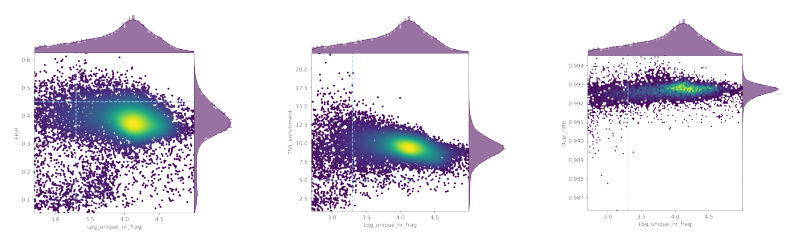

In [27]:
# Filter cell barcodes
                         #[min,  #max]
QC_filters = {
    'Log_unique_nr_frag': [3.3 , None],
    'FRIP':               [0.45, None],
    'TSS_enrichment':     [5   , None],
    'Dupl_rate':          [None, None]

}

# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['timecourse'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['timecourse'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['timecourse'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

In [28]:
bc_passing_filters = {'timecourse':[]}
bc_passing_filters['timecourse'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
pickle.dump(bc_passing_filters,
            open(os.path.join(tmp_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'wb'))
print(f"{len(bc_passing_filters['timecourse'])} barcodes passed QC stats")

1003 barcodes passed QC stats


Missing: Plot a timecourse using the preprocessed scATAC-seq data